In [91]:
import ast
import random
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [92]:
def parse_title(line):
    parsed_line = line.split('===============')[1].split('-')
    animal_type, animal_number = parsed_line[0].strip(), int(parsed_line[1].split(' ')[0])
    return animal_type, animal_number

In [93]:
def parse_timestamp(line):
    return float(line.split(':')[1].strip())

In [94]:
def parse_list(line):
    last_value = line.strip().split('\t')[-1]
    if last_value == '"NaN"':
        return [None, None]
    return map(float, ast.literal_eval(last_value))

In [95]:
def parse_single_value(line):
    last_value = line.strip().split('\t')[-1]
    if last_value == '"NaN"':
        return None
    return float(last_value)

In [96]:
readings = []

with open('Dataset2/log_human_readable.txt') as f:
    first_animal = True
    line_num = 0
    while line := f.readline():
        if line.strip():
            i = line_num % 6
            if i == 0:
                if not first_animal:
                    readings.append({
                        'id': f'{animal_type}-{animal_number}',
                        'species': animal_type,
                        'timestamp': timestamp,
                        'x': x,
                        'y': y,
                        'temp': temp,
                        'humidity': humidity,
                        'pulse': pulse,
                        'oxygen': oxygen,
                    })
                animal_type, animal_number = parse_title(line)
                first_animal = False
            elif i == 1: timestamp = parse_timestamp(line)
            elif i == 2: pulse, oxygen = parse_list(line)        
            elif i == 3: x, y = parse_list(line)    
            elif i == 4: temp = parse_single_value(line)
            elif i == 5: humidity = parse_single_value(line)
            line_num += 1
            
df = pd.DataFrame(readings)
df['id_temp'] = df['id'].apply(lambda x: int(x.split('-')[1]))
df = df.sort_values(['id_temp', 'species', 'timestamp'])
df.drop(columns=['id_temp'], inplace=True)
df.head()

,id,species,timestamp,x,y,temp,humidity,pulse,oxygen
262,Elephant-1,Elephant,234.26,648.2714,980.170,24.47918,22.78991,36.0,94.0
267,Elephant-1,Elephant,236.26,648.2714,980.170,24.47918,22.78991,36.0,94.0
272,Elephant-1,Elephant,238.26,646.1488,987.632,24.44181,22.91481,36.0,94.0
277,Elephant-1,Elephant,240.26,646.1488,987.632,24.44181,22.91481,36.0,94.0
282,Elephant-1,Elephant,242.26,646.1488,987.632,24.44181,22.91481,36.0,94.0


In [97]:
ele = df[df['species'] == 'Elephant']
zeb = df[df['species'] == 'Zebra']
lion = df[df['species'] == 'Lion']

for adf in [ele, zeb, lion]:
    for id in adf.id.unique():
        print(f'{id}: {adf[adf.id == id].shape[0]} readings')
    print()

Elephant-1: 2305 readings
Elephant-4: 2222 readings
Elephant-5: 2294 readings
Elephant-6: 2399 readings
Elephant-11: 2380 readings

Zebra-19: 2272 readings
Zebra-20: 2060 readings
Zebra-23: 2149 readings
Zebra-27: 2360 readings
Zebra-28: 1917 readings
Zebra-30: 2198 readings
Zebra-32: 2342 readings

Lion-12: 1955 readings
Lion-13: 1861 readings
Lion-14: 1979 readings
Lion-15: 2070 readings
Lion-17: 2109 readings



# 1) Is the Zebra population healthy?

In [98]:
zeb.describe()

,timestamp,x,y,temp,humidity,pulse,oxygen
count,15298.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,2647.673097,611.587549,568.389414,27.144059,25.489833,150.010629,93.636667
std,1278.482873,263.250625,289.290737,1.971499,6.673202,0.597999,0.480975
min,124.240000,87.277630,140.346500,23.657050,18.675180,150.000000,93.000000
25%,1564.320000,387.798800,332.284700,25.705070,20.640450,150.000000,93.000000
50%,2658.340000,708.516500,514.319300,26.488960,23.362160,150.000000,94.000000
75%,3750.340000,782.934900,842.414700,29.143070,31.734460,150.000000,94.000000
max,4842.340000,942.031000,998.450000,30.625680,39.194150,187.500000,94.000000


Standard deviation of pulse and oxygen is very low. Suggest very little change in data. Even looking at min and max values of pulse and oxygen, oxygen seems perfectly fine. There is an indication of increased pulse when looking at the max value which is `187.5`.

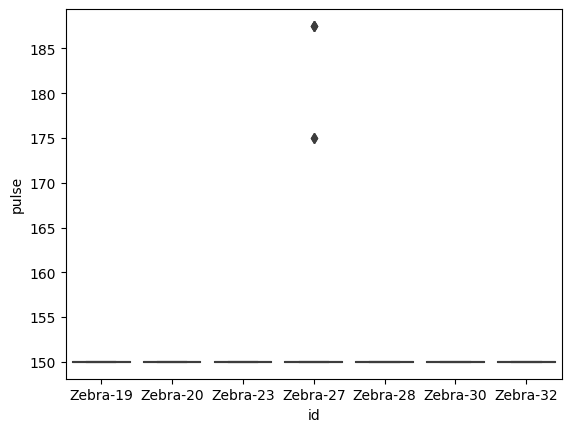

In [99]:
sns.boxplot(x='id', y='pulse', data=zeb);

Only Zebra-27 has a weird pulse.

     timestamp  pulse
106     154.26  175.0
109     156.26  175.0
112     158.26  187.5
116     160.26  187.5
120     162.26  187.5


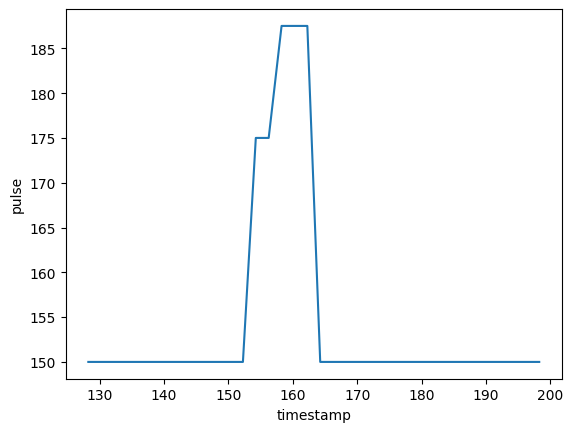

In [100]:
print(zeb[(zeb.id == 'Zebra-27') & (zeb.pulse > 150)][['timestamp', 'pulse']])
sns.lineplot(x='timestamp', y='pulse', data=zeb[(zeb.id == 'Zebra-27') & (zeb.timestamp < 200)]);

### All Zebras are alive, pulse seems stable. Only one Zebra's pulse increased for a very short period of time. From this we can conclude that the zebra population is healthy. There might have been a small incident which caused Zebra-27's pulse to increase for a short time.

# 2) Do the Zebras have enough room to move around in?

In [101]:
zeb.describe()

,timestamp,x,y,temp,humidity,pulse,oxygen
count,15298.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,2647.673097,611.587549,568.389414,27.144059,25.489833,150.010629,93.636667
std,1278.482873,263.250625,289.290737,1.971499,6.673202,0.597999,0.480975
min,124.240000,87.277630,140.346500,23.657050,18.675180,150.000000,93.000000
25%,1564.320000,387.798800,332.284700,25.705070,20.640450,150.000000,93.000000
50%,2658.340000,708.516500,514.319300,26.488960,23.362160,150.000000,94.000000
75%,3750.340000,782.934900,842.414700,29.143070,31.734460,150.000000,94.000000
max,4842.340000,942.031000,998.450000,30.625680,39.194150,187.500000,94.000000


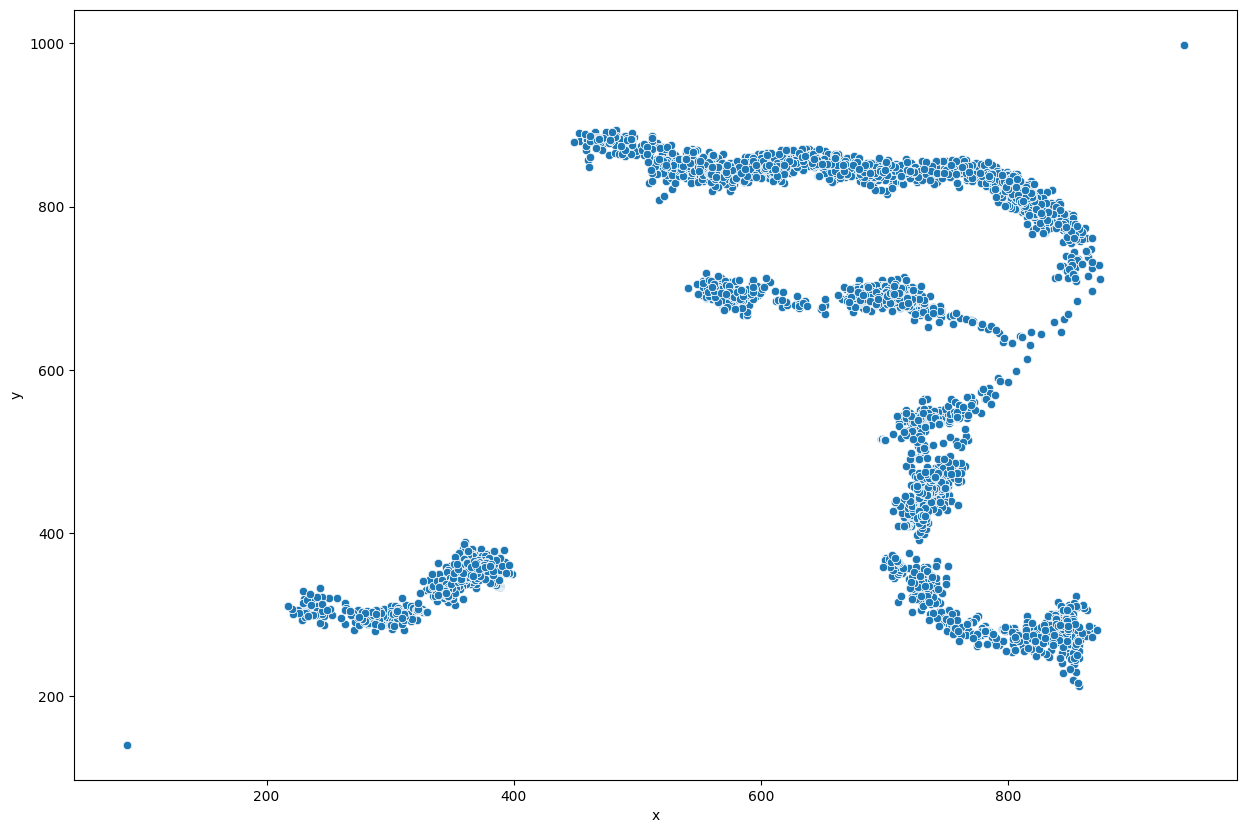

In [102]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x='x', y='y', data=zeb);

### From a 2D plot of the zebra movement, we get a reference for the size of the land they have to graze in. We can see that there is a lot of empty space that they do not make use of. From this we can conclude that the zebras have enough space to move in. We also see that two zebras haven't moved at all. Their pulse and oxygen are still at positive values, so it means they're still alive but not moving.

# 3) Do you see any signs of poachers? If so, where are they?


Zebras seem fine from plots above, checking elephants and lions.

In [103]:
ele.describe()

,timestamp,x,y,temp,humidity,pulse,oxygen
count,11600.000000,11596.000000,11596.000000,11596.000000,11596.000000,11596.000000,11596.000000
mean,2521.571233,593.075317,689.816750,26.479898,23.667323,35.997710,93.643756
std,1342.549565,132.825888,259.243335,2.162895,2.340594,0.080075,0.478909
min,46.240000,277.969700,277.885800,24.400660,19.684940,32.100000,93.000000
25%,1363.820000,467.536300,472.996200,24.836830,22.745440,36.000000,93.000000
50%,2523.340000,643.456300,605.605700,25.472675,23.052530,36.000000,94.000000
75%,3682.840000,721.169200,995.764000,27.809600,24.191390,36.000000,94.000000
max,4842.340000,767.003900,995.778000,30.432910,35.857940,36.000000,94.000000


Pulse and Oxygen seems fine, there is very little standard deviation. Oxygen min and max is 93 and 94 respectively, nothing suspicious. Pulse range is a little higher, so let's check that out:

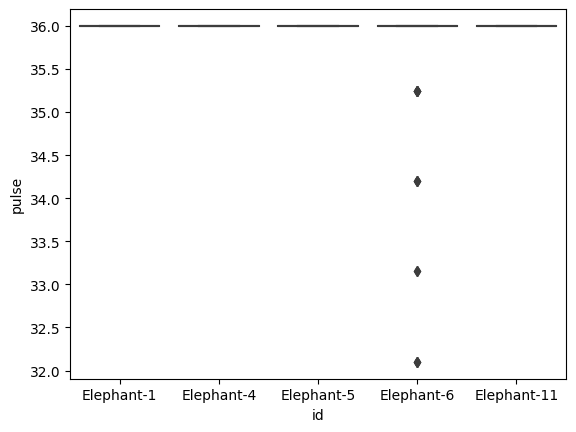

In [104]:
sns.boxplot(x='id', y='pulse', data=ele);

    timestamp  pulse
1       48.24  32.10
2       50.24  32.10
3       52.24  32.10
4       54.24  33.15
5       56.24  33.15
6       58.24  34.20
7       60.24  34.20
8       62.24  34.20
9       64.24  35.25
10      66.24  35.25
11      68.24  35.25
12      70.24  35.25
13      72.24  35.25


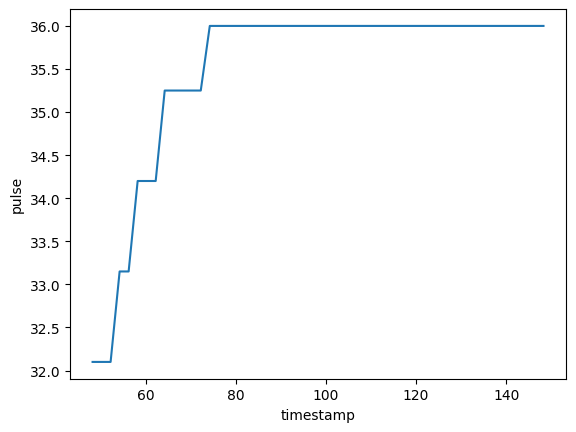

In [105]:
print(ele[(ele.id == 'Elephant-6') & (ele.pulse < 36)][['timestamp', 'pulse']])
sns.lineplot(x='timestamp', y='pulse', data=ele[(ele.id == 'Elephant-6') & (ele.timestamp < 150)]);

Increasing pulse suggest no evidence of poachers. Checking lions.

In [106]:
lion.describe()

,timestamp,x,y,temp,humidity,pulse,oxygen
count,9974.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.0,9967.000000
mean,2844.677985,531.807112,609.278694,26.414120,27.538837,72.0,93.791813
std,1158.382950,298.705947,351.429977,2.877439,4.150198,0.0,0.733300
min,626.300000,1.533510,128.068100,22.841230,22.946380,72.0,93.000000
25%,1850.820000,449.904800,245.637300,24.197280,23.033800,72.0,93.000000
50%,2848.340000,516.439300,766.977700,25.400600,28.745510,72.0,94.000000
75%,3846.340000,794.564200,892.444500,29.422490,30.310750,72.0,94.000000
max,4842.340000,854.578700,998.104000,30.217900,33.560590,72.0,95.000000


Pulse standard deviation is 0, oxygen min and max is 0 93 and 95. All lions are alive. No evidence of poachers.

### All animals' pulse and oxygen are in the positive ranges, there is no evidence of poachers.

# 4) Plot a CDF of the movement speed of Zebras. What do you observe?


Speed = Distance / Time. Since we're looking at the distribution, we can look at all the zebras at once. But for the calculation, we're gonna have to calculate the speed individually per zebra.

In [107]:
zebras = []
for z_id in zeb.id.unique():
    zdf = zeb.copy(deep=True)[zeb['id'] == z_id]
    distances = np.sqrt(np.diff(zdf['x']) ** 2 + np.diff(zdf['y']) ** 2)
    distances = np.insert(distances, 0, np.nan)
    zdf['distance_travelled'] = distances
    zdf['time_diff'] = zdf['timestamp'].diff()
    zdf['speed'] = zdf.distance_travelled / zdf.time_diff
    zebras.append(zdf)
zebras = pd.concat(zebras).reset_index(drop=True)
zebras.head()

,id,species,timestamp,x,y,temp,humidity,pulse,oxygen,distance_travelled,time_diff,speed
0,Zebra-19,Zebra,300.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Zebra-19,Zebra,302.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
2,Zebra-19,Zebra,304.28,574.621,829.379,24.74464,21.11668,150.0,94.0,NaN,2.0,NaN
3,Zebra-19,Zebra,306.28,574.621,829.379,24.74464,21.11668,150.0,94.0,0.0,2.0,0.0
4,Zebra-19,Zebra,308.28,574.621,829.379,24.74464,21.11668,150.0,94.0,0.0,2.0,0.0


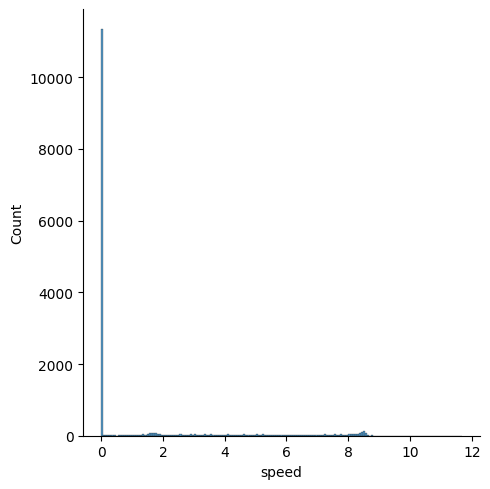

In [108]:
sns.displot(zebras, x='speed');

Seems like they're stationary for the most part, and this is skewing the graph, so let's look at speed values above 0.

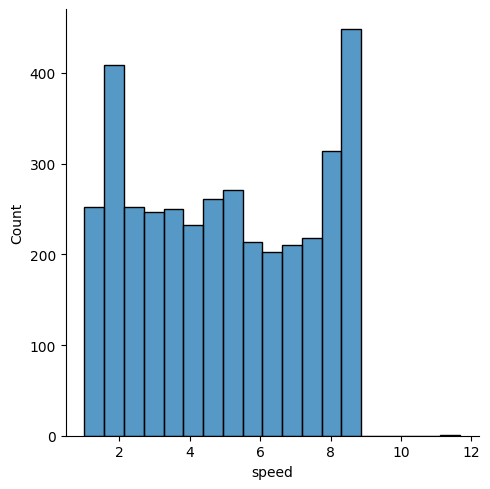

In [109]:
sns.displot(zebras[zebras.speed > 1], x='speed');

### We observe that for the most part, zebras are stationary. The peak towards the end of the distribution also shows us that the zebras accelerate to their max speed and then quickly slow down. This means they're not good at long distance running, but better at quick bursts of acceleration

# 5) Do Zebras make friends? Do you see pairs that tend to stay together? 

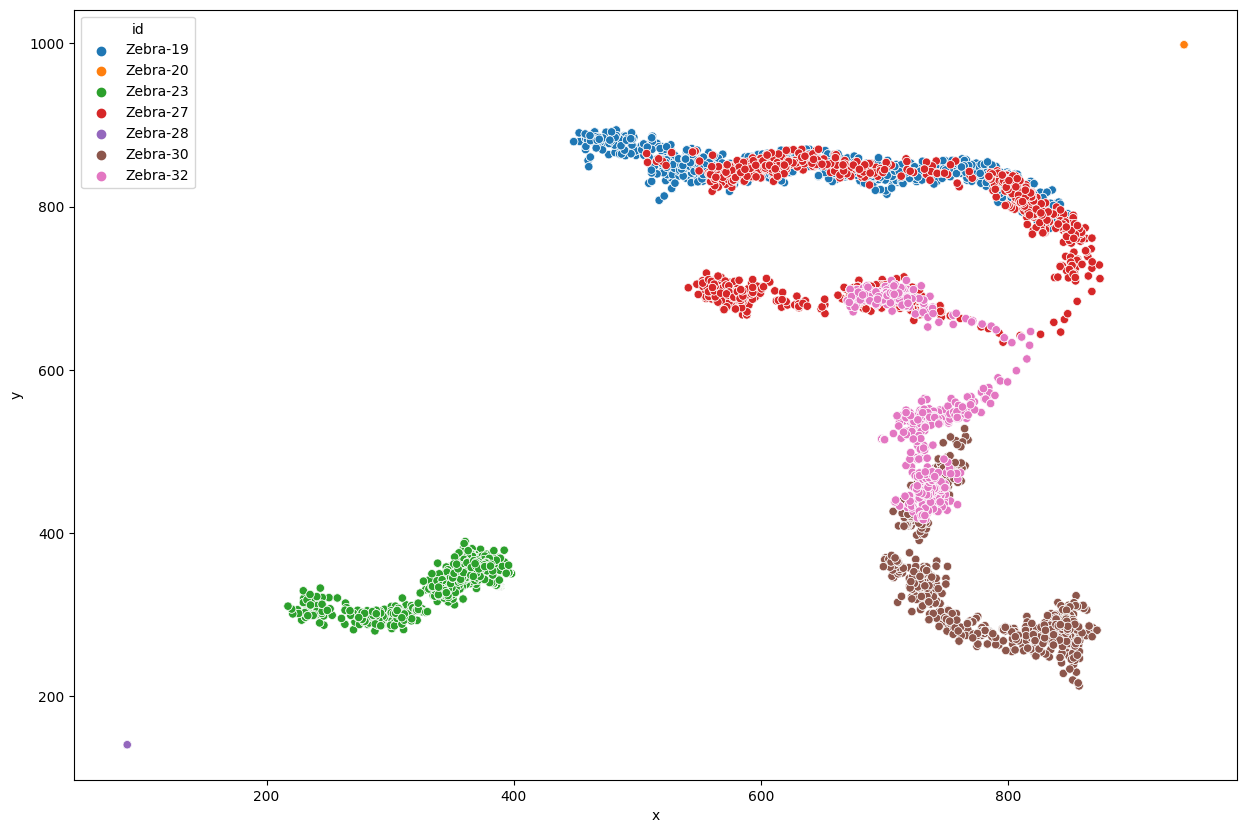

In [110]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x='x', y='y', data=zeb, hue='id');

For the most part, we can see that most zebras tend to stay together. There are two exceptions, wherein three Zebras, the ones ending with 20, 23, 30, are alone.

# 6) What locations do Zebras tend to congregate at? Why do they tend to go there?

We can see from the plot above that zebras concentrate on the right side of the map. To see why, we need to look at two things: predators, and weather (temperature and humidity).

First, predators:

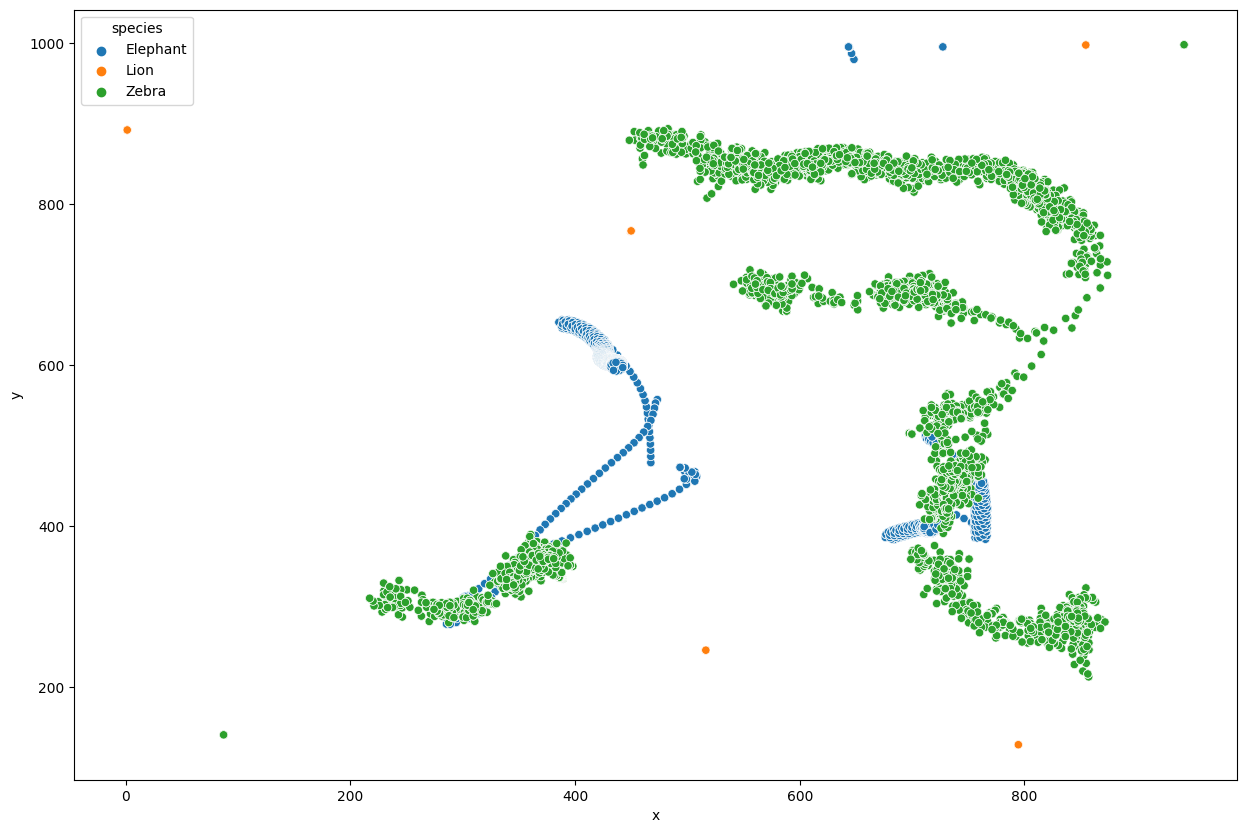

In [111]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x='x', y='y', data=df, hue='species');

Predators don't really seem like a reason for the zebras to congregate in the right side of the map. Let's check the temperature and humidity.

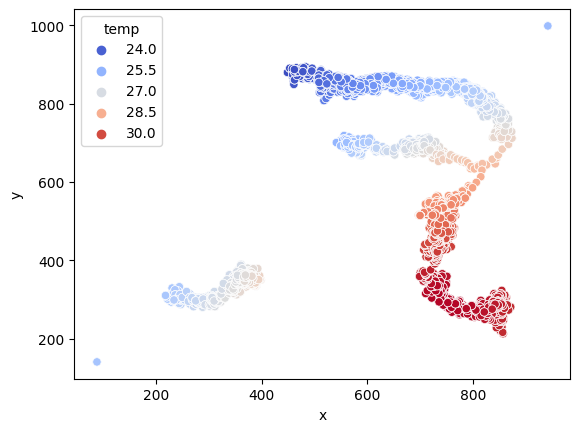

In [112]:
sns.scatterplot(data=zeb, x='x', y='y', hue='temp', palette='coolwarm');

We don't really see a pattern that makes zebras congregate according to the temperature. We zee that the zebras move about areas that range from 24 degrees to 30.

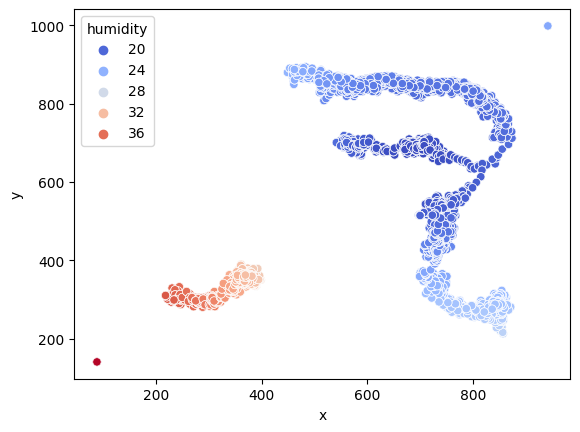

In [113]:
sns.scatterplot(data=zeb, x='x', y='y', hue='humidity', palette='coolwarm');

### There is no pattern seen which shows why zebras tend to congregate.

# 7) Are there any locations Zebras tend to avoid? 


### Zebras for the most part tend to avoid the left side of the map, but the reason for this is unknown. Predator information, temperature, nor humidity seen to have an affect on the areas zebras seem to avoid.

# Finally, step back and do some more experimentation with this platform. You are a scientist that cares about these animals and the health and safety of their population and their surrounding environment. What other questions do you feel should be answered? Do you want to investigate another species, like the lions or elephants? Pick a question and do an investigation of that one as well.